# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']

In [4]:
df = pd.read_csv('data/tab_tick_2019.csv')
df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

,spread_avg,tick_sd,sema_diff,lema_diff,diff,avg_gain,avg_loss,rs,rsi,ssma_diff,lsma_diff,sma_diff,max_gap,min_gap,ema_diff,direction
0,0.000041,0.000004,-0.000044,-0.000015,-0.000009,0.000003,0.000042,0.070397,6.576755,-0.000043,-0.000003,-0.000107,0.000453,0.0,-0.000207,decrease
1,0.000047,0.000011,-0.000039,-0.000015,-0.000019,0.000003,0.000042,0.070583,6.592970,-0.000044,-0.000004,-0.000148,0.000472,0.0,-0.000231,decrease
2,0.000035,0.000023,-0.000043,-0.000016,-0.000048,0.000002,0.000045,0.051753,4.920611,-0.000052,-0.000004,-0.000195,0.000488,0.0,-0.000258,decrease
3,0.000041,0.000057,-0.000066,-0.000023,-0.000149,0.000002,0.000054,0.043435,4.162707,-0.000064,-0.000007,-0.000252,0.000569,0.0,-0.000301,decrease
4,0.000045,0.000024,-0.000079,-0.000028,-0.000130,0.000002,0.000058,0.040463,3.888955,-0.000070,-0.000010,-0.000312,0.000663,0.0,-0.000353,decrease


In [5]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df, apply_smote = False)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 291806
--------------------------
increase    110987
decrease    109166
same         71653
Name: direction, dtype: int64
--------------------------
increase    0.380345
decrease    0.374105
same        0.245550
Name: direction, dtype: float64


['data/model/y_map.pkl']

## Neural Network

### Network building

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [7]:
model = Sequential([
    Dense(units = 2048, activation='relu', input_shape=(len(train_x[0]),)),
    Dense(units = 1024, activation='relu',),
    Dense(units = 512, activation='relu'),    
    Dense(units = 256, activation='relu'),
    Dense(units = 128, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(    
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.01),
    metrics=CategoricalAccuracy())

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              32768     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 2,820,355
Trainable params: 2,820,355
Non-trainable params: 0
______________________________________________

### Training

In [8]:
epoch_val         = 10
batch_size_val    = 1024

verbose_val       = 2
workers_val       = -1

In [9]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
          verbose=verbose_val)

Epoch 1/10
228/228 - 4s - loss: 0.6441 - categorical_accuracy: 0.7193 - val_loss: 0.6103 - val_categorical_accuracy: 0.7292
Epoch 2/10
228/228 - 3s - loss: 0.6067 - categorical_accuracy: 0.7310 - val_loss: 0.6074 - val_categorical_accuracy: 0.7309
Epoch 3/10
228/228 - 3s - loss: 0.6046 - categorical_accuracy: 0.7318 - val_loss: 0.6066 - val_categorical_accuracy: 0.7312
Epoch 4/10
228/228 - 2s - loss: 0.6035 - categorical_accuracy: 0.7321 - val_loss: 0.6058 - val_categorical_accuracy: 0.7313
Epoch 5/10
228/228 - 2s - loss: 0.6029 - categorical_accuracy: 0.7322 - val_loss: 0.6053 - val_categorical_accuracy: 0.7318
Epoch 6/10
228/228 - 2s - loss: 0.6026 - categorical_accuracy: 0.7326 - val_loss: 0.6054 - val_categorical_accuracy: 0.7314
Epoch 7/10
228/228 - 2s - loss: 0.6022 - categorical_accuracy: 0.7330 - val_loss: 0.6051 - val_categorical_accuracy: 0.7318
Epoch 8/10
228/228 - 2s - loss: 0.6020 - categorical_accuracy: 0.7328 - val_loss: 0.6050 - val_categorical_accuracy: 0.7313
Epoch 9/

### DNN

In [10]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.78      0.83      0.80     21887
    increase       0.78      0.83      0.80     22017
        same       0.54      0.44      0.49     14458

    accuracy                           0.73     58362
   macro avg       0.70      0.70      0.70     58362
weighted avg       0.72      0.73      0.73     58362



In [11]:
model.save('data/model/model_dnn.h5') 
model_new = load_model('data/model/model_dnn.h5')

### DNN Prediction

Record count : 260430
--------------------------
decrease    110264
increase    109156
same         41010
Name: direction, dtype: int64
--------------------------
decrease    0.423392
increase    0.419138
same        0.157470
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.83      0.78      0.81    110264
    increase       0.83      0.78      0.81    109156
        same       0.36      0.47      0.41     41010

    accuracy                           0.73    260430
   macro avg       0.67      0.68      0.67    260430
weighted avg       0.76      0.73      0.74    260430



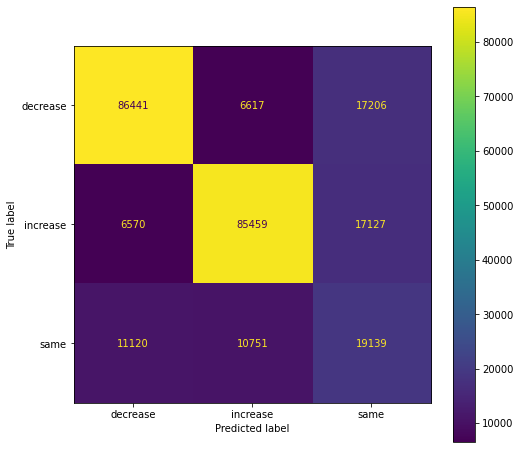

In [12]:
df1 = pd.read_csv('data/tab_tick_2018.csv')
df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

predictions = model_new.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

model_new = load_model('data/model/model_dnn.h5')    
scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 

x_scaled = scaler_obj.transform(live_df.values)
predictions = model_new.predict(x_scaled) 
rounded_predictions = np.argmax(predictions, axis = -1)

#live_df['predictions'] = y_map[data['rounded_predictions'][0]]
live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()